This notebook contains code related to downloading the dataset, and converting it into a list of tuples $(h,r,t)$ (corresponding to head, relation, tail). The list is stored in `data/dataset.tsv`. Next to it, we store lookup tables for the types of targets and regulators. (`data/target2type.csv` and `data/regulator2type.csv` respectively.)

In [23]:
import collections
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

### 🛒  Download and load dataset

In [2]:
!mkdir -p data
!wget https://lnctard.bio-database.com/downloadfile/lnctard2.0.zip -qO- | zcat > data/lnctard2.0.txt

load raw dataset, for some reason `utf-8` does not work for decoding, but `latin-1` seems to work

In [3]:
lnctard = pd.read_csv("data/lnctard2.0.txt", sep="\t", encoding="latin-1")

coerce raw dataset into DataFrame preserving only relevant columns

In [4]:
important_cols = ["Regulator", "Target", "SearchregulatoryMechanism", 
                  "RegulatorType", "TargetType"]
df = lnctard[important_cols]

In [5]:
df.head()

,Regulator,Target,SearchregulatoryMechanism,RegulatorType,TargetType
0,LINC00313,miR-4429,ceRNA or sponge,lncRNA,miRNA
1,FAM83H-AS1,CDKN1A,epigenetic regulation,lncRNA,PCG
2,NEAT1,TGFB1,ceRNA or sponge,lncRNA,PCG
3,NEAT1,ZEB1,ceRNA or sponge,lncRNA,TF
4,ZFPM2-AS1,MIF,interact with protein,lncRNA,PCG


In [39]:
len(df)

8360

### 🧐 Raw dataset inspections

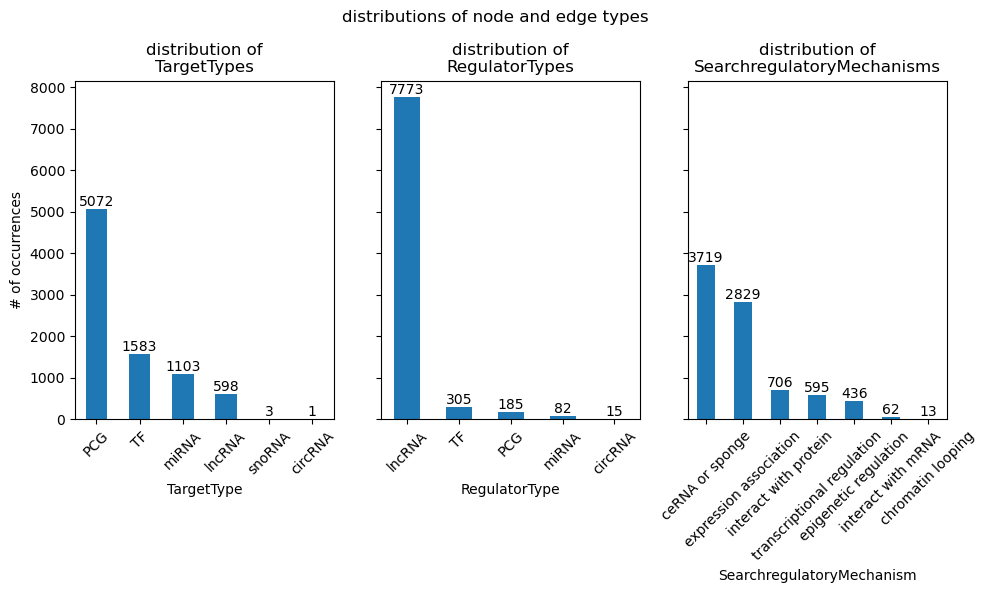

In [6]:
dis_features = ["TargetType", "RegulatorType", "SearchregulatoryMechanism"]
fig, axs = plt.subplots(ncols=len(dis_features), figsize=(10,6), sharey=True)
fig.suptitle("distributions of node and edge types")
for ax, ty in zip(axs, dis_features):
  # show distribution with bar plot
  df[ty].value_counts().plot(
    kind="bar", ax=ax, title=f"distribution of\n{ty}s",
    ylabel="# of occurrences", rot=45,
  )
  # stick numbers on bars
  for cont in ax.containers:
    ax.bar_label(cont)
fig.tight_layout()

In [7]:
(f'there are {df["Regulator"].nunique()} different Regulators, and ' +
 f'{df["Target"].nunique()} different Targets')

'there are 1599 different Regulators, and 2758 different Targets'

### 🥗 Convert dataset to `networkx` graph

In [8]:
G = nx.from_pandas_edgelist(
  df, source="Regulator", target="Target",
  edge_attr="SearchregulatoryMechanism",
  create_using=nx.DiGraph(),
)
len(G.nodes),len(G.edges)

(3908, 7067)

find all weakly (_TODO: find out whether the digraph representation is desired and decide whether we want weakly or strongly connected components._) connected components (CC) in graph and extract largest one

In [9]:
conn_comps = sorted(nx.weakly_connected_components(G), key=len, reverse=True)
len(conn_comps)

249

In [16]:
len(conn_comps[0])

3367

In [19]:
largest_cc = conn_comps[0]
len(largest_cc), len(conn_comps[1]) # size of largest and 2nd largest CC

(3367, 6)

inspect types of regulators in 2nd largest CC

In [96]:
df[df["Regulator"].isin(conn_comps[1])][["Regulator", "RegulatorType"]].drop_duplicates()

,Regulator,RegulatorType
177,IFNG-AS1,lncRNA
5325,IFN¦Ã,PCG
5326,IFN¦Ã,TF


In [97]:
df[df["Target"].isin(conn_comps[1])][["Target", "TargetType"]].drop_duplicates()

,Target,TargetType
177,ESRP2,PCG
1239,HLA-DRB1,PCG
5325,IFNG-AS1,lncRNA
5326,MAFTRR,lncRNA
8247,miR-627-3p,miRNA


plot 2nd largest CC to see what our data could look like

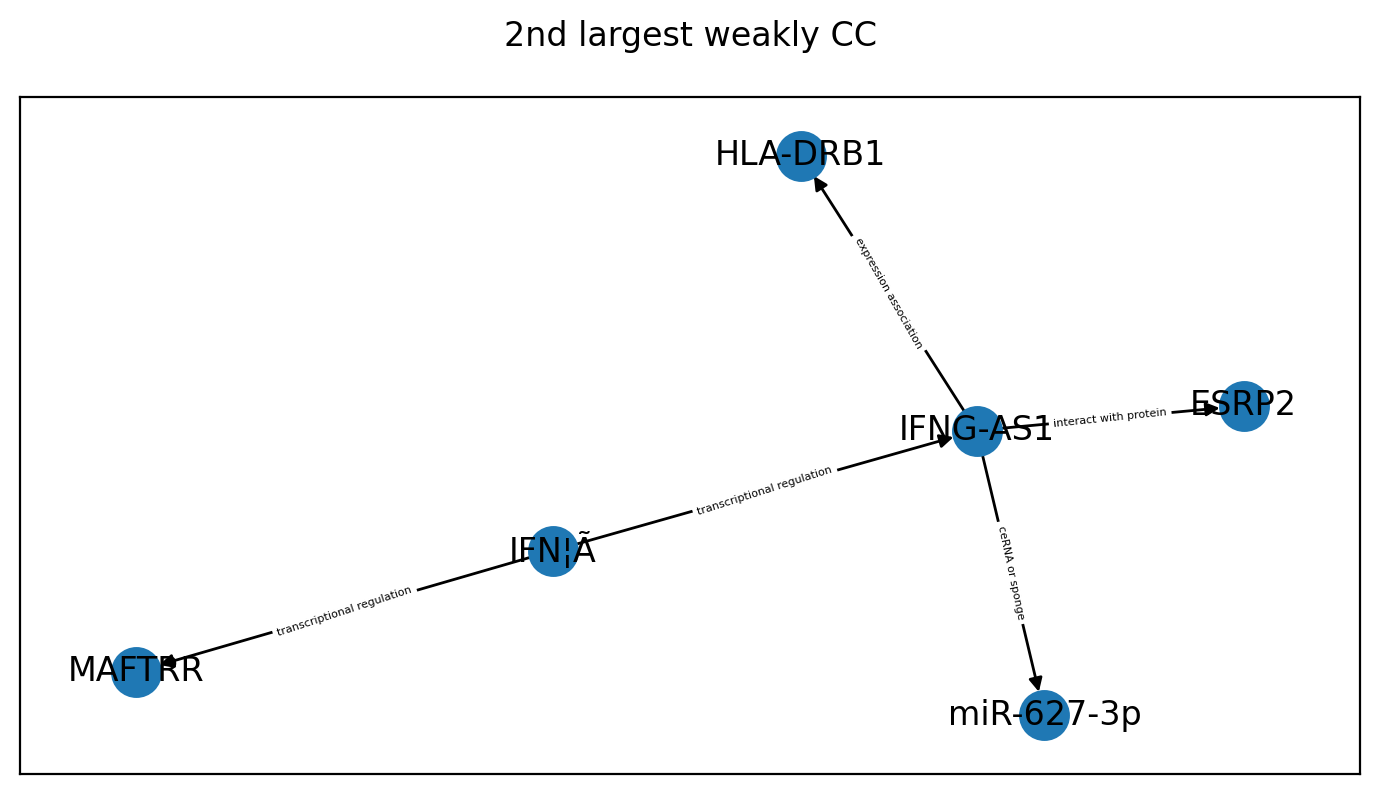

In [106]:
fig, ax = plt.subplots(figsize=(7,4), dpi=200)
fig.suptitle("2nd largest weakly CC")
snd_cc = G.subgraph(conn_comps[1])
pos = nx.spring_layout(snd_cc)
nx.draw_networkx_nodes(snd_cc, pos, ax=ax, node_size=300)
nx.draw_networkx_labels(snd_cc, pos)
nx.draw_networkx_edges(snd_cc, pos, arrows = True)
nx.draw_networkx_edge_labels(
  snd_cc,
  pos,
  nx.get_edge_attributes(snd_cc, "SearchregulatoryMechanism"),
  ax=ax,
  font_size=4,
)
fig.tight_layout()

### 🧐 Graph inspections

In [21]:
# convert node set to actual graph object
largest_cc = G.subgraph(largest_cc)

/tmp/ipykernel_3834/2134426100.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(len(regtys), 1, idx + 1, sharex=plt.gca())


(0.0, 40.0)

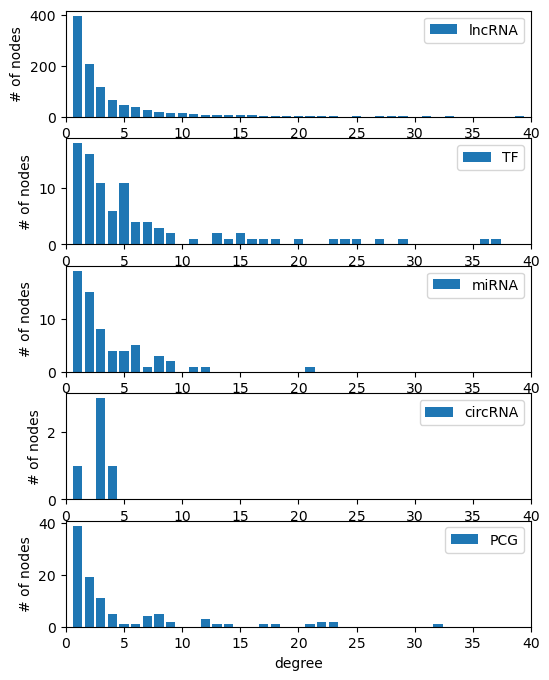

In [86]:
plt.figure(figsize=(6,8))
regtys = df["RegulatorType"].drop_duplicates()
for idx, regty in enumerate(regtys):
  regs = df[df["RegulatorType"] == regty]["Regulator"].drop_duplicates()
  _, degrees = zip(*largest_cc.degree(regs))
  degrees = collections.Counter(degrees)
  plt.subplot(len(regtys), 1, idx + 1, sharex=plt.gca())
  plt.bar(degrees.keys(), degrees.values(), label=regty)
  #plt.hist(degrees.values(), list(degrees.keys()), label=regty)
  plt.xlabel("degree")
  plt.ylabel("# of nodes")
  plt.legend()
plt.xlim(0,40)

/tmp/ipykernel_3834/1954681958.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(len(regtys), 1, idx + 1, sharex=plt.gca())


(0.0, 40.0)

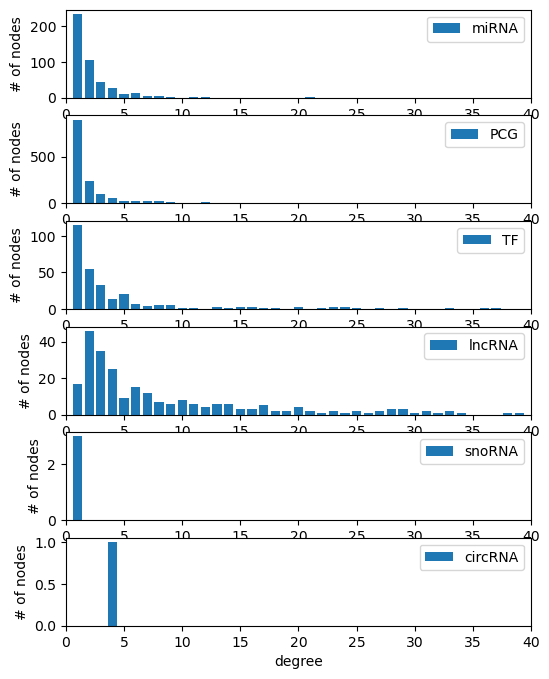

In [87]:
plt.figure(figsize=(6,8))
regtys = df["TargetType"].drop_duplicates()
for idx, regty in enumerate(regtys):
  regs = df[df["TargetType"] == regty]["Target"].drop_duplicates()
  _, degrees = zip(*largest_cc.degree(regs))
  degrees = collections.Counter(degrees)
  plt.subplot(len(regtys), 1, idx + 1, sharex=plt.gca())
  plt.bar(degrees.keys(), degrees.values(), label=regty)
  #plt.hist(degrees.values(), list(degrees.keys()), label=regty)
  plt.xlabel("degree")
  plt.ylabel("# of nodes")
  plt.legend()
plt.xlim(0,40)

### 🛍️ Extract tuples and store dataset

In [351]:
# create tuples (h,r,t)
edgedata = largest_cc.edges.data("SearchregulatoryMechanism")
tuples = [(h,r,t) for h,t,r in edgedata] # swizzle t and r
tuples = pd.DataFrame(tuples, columns=["head","relation","tail"])
print("gathered",len(tuples),"tuples")
tuples.head()

gathered 6773 tuples


,head,relation,tail
0,LINC00313,ceRNA or sponge,miR-4429
1,LINC00313,transcriptional regulation,SOX2
2,LINC00313,ceRNA or sponge,MIR422A
3,LINC00313,ceRNA or sponge,FOSL2
4,LINC00313,epigenetic regulation,ALX4


In [352]:
tuples.to_csv("data/dataset.tsv", sep="\t", index=False)

obtain from targets to target types and regulators to regulator types.

In [353]:
target2type = df[["Target","TargetType"]].drop_duplicates(ignore_index=True)
target2type.head()

,Target,TargetType
0,miR-4429,miRNA
1,CDKN1A,PCG
2,TGFB1,PCG
3,ZEB1,TF
4,MIF,PCG


In [354]:
regulator2type = df[["Regulator","RegulatorType"]].drop_duplicates(ignore_index=True)
regulator2type.head()

,Regulator,RegulatorType
0,LINC00313,lncRNA
1,FAM83H-AS1,lncRNA
2,NEAT1,lncRNA
3,ZFPM2-AS1,lncRNA
4,SNHG1,lncRNA


store mappings

In [355]:
target2type.to_csv("data/target2type.tsv", sep="\t", index=False)
regulator2type.to_csv("data/regulator2type.tsv", sep="\t", index=False)